Мышковец С.А., v.1 01.05.2023

**Решение задачи:**

ДЗ - оценить возраст человека по изображению. 

Выполнить оптимизацию ранее написанных нейронных сетей. Выбор на ваше усмотрение (лучше брать что то что относительно большое).

Используйте Сore Ml Tools. Сравните квантование float16 и float32. 
Дополнительно : tensorflow-lite
Выполнить тестирование времени вывода и опреледилть есть ли падение точности. 

**Вывод**

| Модель | mae | time predict on 2842 test images
| -----------  |----------- |----------- |
| mobile_model (tf model) |  6,16 | 01:46
| model (ML Model) | 6,11 | 37:43 
| loaded_model_fp16 (ML Model with float 16 quantized weights) | 6,34 | 01:46
| loaded_model_bit8 (ML Model with 8 bit quantized weights) | 7,85 | 01:34
| core_ml_model_16 (ML Program) |  6,20 | 00:24
| core_ml_model_32 (ML Program) |  6,17 | 00:22

ML Model

Конвертация mobile_model в модель model (ML Model) значительно увеличила время вывода предикта. 

Конвертация mobile_model в модель model (ML Model) с квантование весов до float 16 позволило сохранить время вывода предикта, но уменьшила mae на 0,2.

Конвертация mobile_model в модель model (ML Model) с квантование весов до 8 bit позволило слегка снизить время вывода предикта, но уменьшила mae на 1,74.

ML Program

Конвертация mobile_model в core_ml_model_16 (ML Program) и core_ml_model_32 (ML Program) значительно уменьшило время вывода предикта и не повлияла на качество модели.

MAE рассчитан при помощи sklearn.metrics.mean_absolute_error() для чистоты эксперимента на всем тестовом наборе данных.


# Загрузим необходимые библиотеки и проведем разведовательный анализ данных.

In [ ]:
# pip install coremltools

In [41]:
# pip install -q tensorflow-model-optimization

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot

import coremltools as ct

from PIL import Image

import gc
from tqdm import tqdm
import sys
import os

OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


scikit-learn version 1.2.1 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [6]:
# Define loss visualization function
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

In [6]:
import os
main_dir = os.getcwd()

In [7]:
main_dir

'/Users/sviatlanamyshkavets/Documents/Courses/DS TM/47 Композиция глубоких сетей/HW33_Myshkavets S.A.'

In [8]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/UTKFace"

In [9]:
# Extract age values from file names
age = []
for file in os.listdir(ImgLocation):
    file = int(file.split('_')[0])
    age.append(file)

In [7]:
len(age)

23708

In [10]:
# Extract paths for further data exploration
full_path = []
for file in os.listdir(ImgLocation):
    path = ImgLocation + '/' + file
    full_path.append(path)

In [11]:
# Create pd DataFrame
df = pd.DataFrame({'age': age,  
                   'full_path': full_path, 
                   }
                 )

In [12]:
df.head()

,age,full_path
0,9,/Users/sviatlanamyshkavets/Documents/Courses/D...
1,36,/Users/sviatlanamyshkavets/Documents/Courses/D...
2,86,/Users/sviatlanamyshkavets/Documents/Courses/D...
3,26,/Users/sviatlanamyshkavets/Documents/Courses/D...
4,1,/Users/sviatlanamyshkavets/Documents/Courses/D...


In [9]:
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23708 non-null  int64 
 1   full_path  23708 non-null  object
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


**Выведем фотографии из файлов, частично проверим верность целевых меток.**

**При необходимости при помощи кода ниже пробежимся по папкам и проверим фото детей до 18 лет, удалим явные выбросы. В нашем случае выбран очищенный датасет.**

In [ ]:
test = df[df['age']==1]
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in test['full_path']:
#     img = cv2.imread(file)
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.xlabel(i)
    print(i)
    plt.show()

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

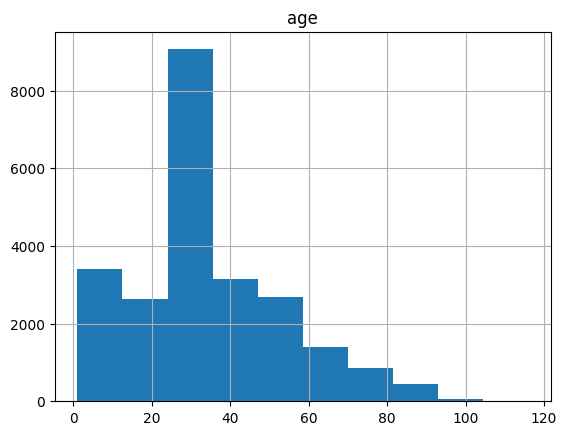

In [13]:
# Explore age distribution
df.hist()

In [12]:
df.groupby('age')['age'].count().sort_values()

age
111       1
103       1
101       2
91        2
115       3
       ... 
24      859
35      880
28      918
1      1123
26     2197
Name: age, Length: 104, dtype: int64

In [13]:
# Delete age values over 99 years
index_age_100 = df[df['age']>99].index
df.drop(index_age_100 , inplace=True)

In [15]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['age'] = labelencoder.fit_transform(df['age'])

#  Подготовим данные для обучения модели и/или использования для её оценки.

**Разделим данные на тренировочную, тестовую и валидационную выборку.**

In [14]:
from sklearn.model_selection import train_test_split

y = df['age']
X = df['full_path']

In [15]:
train_full, test= train_test_split(
    df, test_size=0.12, stratify=df['age'], random_state=0)

In [16]:
train_full.groupby('age')['age'].count()

age
1     988
2     424
3     254
4     240
5     173
     ... 
92     12
93      4
95      8
96     15
99      8
Name: age, Length: 96, dtype: int64

In [17]:
train_full.shape

(20834, 2)

In [18]:
# Extract valid from train
train, valid = train_full[:-5500], train_full[-5500:]

In [19]:
test.shape

(2842, 2)

In [20]:
test.groupby('age')['age'].count()

age
1     135
2      58
3      35
4      33
5      23
     ... 
92      1
93      1
95      1
96      2
99      1
Name: age, Length: 95, dtype: int64

In [77]:
# Create necessary folders for image storage
os.makedirs('train')

In [78]:
os.makedirs('test')

In [79]:
os.makedirs('valid')

In [21]:
# Create lists for train/test/valid images
train_files = []
for i in train['full_path']:
    train_files.append(i)
for a in train['age']:
    train_files.append(a)

In [22]:
test_files = []
for i in test['full_path']:
    test_files.append(i)
for a in test['age']:
    test_files.append(a)

In [23]:
valid_files = []
for i in valid['full_path']:
    valid_files.append(i)
for a in valid['age']:
    valid_files.append(a)

In [28]:
train_dir = main_dir + '/train'
test_dir = main_dir + '/test'
valid_dir = main_dir + '/valid'

In [84]:
for filename in os.listdir(ImgLocation):
    if filename != '.DS_Store':
        # for i in os.listdir(ImgLocation + '/' + filename):
        file = ImgLocation + '/' + filename
        if file in train_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img]) # Some images are in  greyscale (1 channel), 
                                                     # therefore convert them to 3 channel
            path = train_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in test_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = test_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in valid_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = valid_dir
            cv2.imwrite(os.path.join(path, filename), img)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
train_datagen=ImageDataGenerator(rescale=1./255.)

In [26]:
test_datagen=ImageDataGenerator(rescale=1./255.)

In [27]:
valid_datagen=ImageDataGenerator(rescale=1./255.)

In [28]:
TARGET_SIZE = (224,224)

train_gen=train_datagen.flow_from_dataframe(
dataframe=train,
directory=main_dir + '/train',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

valid_gen=train_datagen.flow_from_dataframe(
dataframe=valid,
directory=main_dir + '/valid',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

test_gen=test_datagen.flow_from_dataframe(
dataframe=test,
directory=main_dir + '/test',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

Found 15334 validated image filenames.
Found 5500 validated image filenames.
Found 2842 validated image filenames.


---

In [ ]:
# pip install coremltools==6.2
# c coremltools==6. работает predict() в ML Model
# c coremltools==6.3 не работает predict() в ML Model и ML program

# Загрузим ранее обученную модель MobilenetModel.weights.hdf5.

In [29]:
# load trained model
mobile_model =  tf.keras.models.load_model('MobilenetModel.weights.hdf5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [30]:
# Evaluate the model 
mobile_model.evaluate(test_gen)

89/89 [==============================] - 5s 54ms/step - loss: 75.1489 - mae: 6.1353


[75.1489028930664, 6.135344505310059]

In [36]:
# Predict on 2842 images (len of test)
NUM_IMAGES = 2842
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected = []
predicted = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)
    predict = mobile_model.predict(img_reshaped, verbose=0)[0][0];
    
    expected.append (float(link[1].split('/')[9].split('_')[0]))
    predicted.append (predict)

Prediction: 2842it [01:46, 26.61it/s]


In [37]:
# Evaluate the model
mean_absolute_error(expected, predicted)

6.162460214823463

---

# Конвертируем модель в формат ML Model.

In [38]:
# convert the model to mlmodel
model = ct.convert(mobile_model)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 273/273 [00:03<00:00, 84.09 ops/s]  


Prediction: 28
Actual age: 28


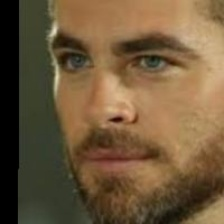

In [145]:
# preprocess image
path = '28_0_0_20170117145726220.jpg.chip.jpg'
image = plt.imread(path)
img_resized = cv2.resize (image, (224,224))/255 #,
img_reshaped  = img_resized.reshape (1,224,224,3)

# make prediction
spec = model.get_spec()
model_input_name = spec.description.input[0].name
model_output_name = spec.description.output[0].name

coreml_out = model.predict({model_input_name : img_reshaped})
coreml_output_tensor = coreml_out[model_output_name]

imageFile = path
image = Image.open(imageFile)
image

print("Prediction:", int(coreml_output_tensor))
print("Actual age:", path.split('_')[0])
image

In [39]:
# Predict on 2842 images 
NUM_IMAGES = 2842
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected_model = []
predicted_model = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)

    spec = model.get_spec()
    model_input_name = spec.description.input[0].name
    model_output_name = spec.description.output[0].name

    coreml_out = model.predict({model_input_name : img_reshaped})
    coreml_output_tensor = coreml_out[model_output_name]
    
    expected_model.append (float(link[1].split('/')[9].split('_')[0]))
    predicted_model.append (float(coreml_output_tensor))

Prediction: 2842it [37:43,  1.26it/s]


In [40]:
# Evaluate the model
mean_absolute_error(expected_model, predicted_model)

6.117178519633268

In [41]:
# Save model as a Core ML model package
model.save("core_mobile_model.mlmodel")

In [2]:
# Load the saved model
loaded_model = ct.models.MLModel("core_mobile_model.mlmodel")

Prediction: 37
Actual age: 56


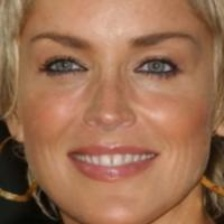

In [143]:
# check if prediction works on the loaded model

# preprocess image
path = '56_1_0_20170110153837637.jpg.chip.jpg'
image = plt.imread(path)
img_resized = cv2.resize (image, (224,224))/255 #,
img_reshaped  = img_resized.reshape (1,224,224,3)

# make prediction
spec = loaded_model.get_spec()
model_input_name = spec.description.input[0].name
model_output_name = spec.description.output[0].name

coreml_out = loaded_model.predict({model_input_name : img_reshaped})
coreml_output_tensor = coreml_out[model_output_name]

imageFile = path
image = Image.open(imageFile)
image

print("Prediction:", int(coreml_output_tensor))
print("Actual age:", path.split('_')[0])
image

**Произведем квантование весов модели ML Model до Float 16.**

In [5]:
from coremltools.models.neural_network import quantization_utils
loaded_model_fp16 = quantization_utils.quantize_weights(loaded_model, nbits=16)

Quantizing using linear quantization
Quantizing layer Mobilenet_Model/conv1_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_1_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_1_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_2_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_2_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_3_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_3_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_4_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_4_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_5_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_5_bn/FusedBatchNormV3_nchw of type convolution

In [30]:
# Predict on 2842 images 
NUM_IMAGES = 2842
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected_loaded_model_fp16 = []
predicted_loaded_model_fp16 = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)

    spec = loaded_model_fp16.get_spec()
    model_input_name = spec.description.input[0].name
    model_output_name = spec.description.output[0].name

    coreml_out = loaded_model_fp16.predict({model_input_name : img_reshaped})
    coreml_output_tensor = coreml_out[model_output_name]
    
    expected_loaded_model_fp16.append (float(link[1].split('/')[9].split('_')[0]))
    predicted_loaded_model_fp16.append (float(coreml_output_tensor))

Prediction: 2842it [01:46, 26.77it/s]


In [31]:
# Evaluate the model
mean_absolute_error(expected_loaded_model_fp16, predicted_loaded_model_fp16)

6.344929749113334

**Произведем квантование весов модели ML Model до 8 bits.**

In [35]:
from coremltools.models.neural_network.quantization_utils import quantize_weights

# quantize to 8 bit using linear mode
loaded_model_8bit = quantize_weights(loaded_model, nbits=8)

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Finished optimizing network. Quantizing neural network..
Quantizing layer Mobilenet_Model/conv1_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_1_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_1_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_2_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_2_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_3_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_3_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_4_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_pw_4_bn/FusedBatchNormV3_nchw of type convolution
Quantizing layer Mobilenet_Model/conv_dw_5_bn/FusedBatchNormV3_nchw of 

In [37]:
# Predict on 2842 images 
NUM_IMAGES = 2842
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected_loaded_model_8bit = []
predicted_loaded_model_8bit = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)

    spec = loaded_model_8bit.get_spec()
    model_input_name = spec.description.input[0].name
    model_output_name = spec.description.output[0].name

    coreml_out = loaded_model_8bit.predict({model_input_name : img_reshaped})
    coreml_output_tensor = coreml_out[model_output_name]
    
    expected_loaded_model_8bit.append (float(link[1].split('/')[9].split('_')[0]))
    predicted_loaded_model_8bit.append (float(coreml_output_tensor))

Prediction: 2842it [01:34, 30.05it/s]


In [38]:
# Evaluate the model
mean_absolute_error(expected_loaded_model_8bit, predicted_loaded_model_8bit)

7.85279464544984

---

# Конвертируем модель в формат ML Program с точностью FLOAT16.

**Float 16 Default**

For ML programs, coremltools 5.0b3 and higher, produces a model with float 16 precision by default (previous beta versions produced float 32 by default). You can override the default precision by using the compute_precision parameter of coremltools.convert().

In [43]:
# covert the model and set the ML Program Precision FLOAT16 (optional)
core_ml_model_16 = ct.convert(mobile_model, 
                   convert_to="mlprogram", 
                   compute_precision=ct.precision.FLOAT16)

Running MIL Clean up passes: 100%|██████████| 11/11 [00:00<00:00, 16.56 passes/s]


Prediction: 28
Actual age: 28


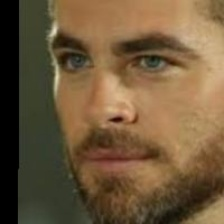

In [146]:
path = '28_0_0_20170117145726220.jpg.chip.jpg'
image = plt.imread(path)
img_resized = cv2.resize (image, (224,224))/255 #,
img_reshaped  = img_resized.reshape (1,224,224,3)
# make prediction
spec = core_ml_model_16.get_spec()
model_input_name = spec.description.input[0].name
model_output_name = spec.description.output[0].name

coreml_out = core_ml_model_16.predict({model_input_name : img_reshaped})
coreml_output_tensor = coreml_out[model_output_name]

imageFile = path
image = Image.open(imageFile)
image

print("Prediction:", int(coreml_output_tensor))
print("Actual age:", path.split('_')[0])
image

In [45]:
# Predict on 2842 images 
NUM_IMAGES = 2842
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected_core_ml_model_16 = []
predicted_core_ml_model_16 = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)

    spec = core_ml_model_16.get_spec()
    model_input_name = spec.description.input[0].name
    model_output_name = spec.description.output[0].name

    coreml_out = core_ml_model_16.predict({model_input_name : img_reshaped})
    coreml_output_tensor = coreml_out[model_output_name]
    
    expected_core_ml_model_16.append (float(link[1].split('/')[9].split('_')[0]))
    predicted_core_ml_model_16.append (float(coreml_output_tensor))

Prediction: 2842it [00:24, 118.26it/s]


In [46]:
# Evaluate the model
mean_absolute_error(expected_core_ml_model_16, predicted_core_ml_model_16)

6.208387565310785

In [ ]:
# Save model as a Core ML model 
model.save("core_mobile_model_16.mlmodel")

In [148]:
# Load the saved model
loaded_model_16 = ct.models.MLModel("core_mobile_model_16.mlmodel")

Prediction: 37
Actual age: 56


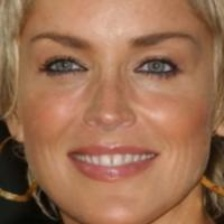

In [151]:
path = '56_1_0_20170110153837637.jpg.chip.jpg'
image = plt.imread(path)
img_resized = cv2.resize (image, (224,224))/255 #,
img_reshaped  = img_resized.reshape (1,224,224,3)
# make prediction
spec = loaded_model_16.get_spec()
model_input_name = spec.description.input[0].name
model_output_name = spec.description.output[0].name

coreml_out = loaded_model_16.predict({model_input_name : img_reshaped})
coreml_output_tensor = coreml_out[model_output_name]

imageFile = path
image = Image.open(imageFile)
image

print("Prediction:", int(coreml_output_tensor))
print("Actual age:", path.split('_')[0])
image

---

# Конвертируем модель в формат ML Program с точностью FLOAT32.

In [47]:
# covert the model and set the ML Program Precision FLOAT32 (optional)
core_ml_model_32 = ct.convert(mobile_model, 
                   convert_to="mlprogram", 
                   compute_precision=ct.precision.FLOAT32)

Running MIL Clean up passes: 100%|██████████| 11/11 [00:00<00:00, 55.38 passes/s]


Prediction: 0
Actual age: 1


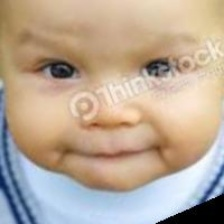

In [152]:
path = '1_0_0_20161219140623097.jpg.chip.jpg'
image = plt.imread(path)
img_resized = cv2.resize (image, (224,224))/255 #,
img_reshaped  = img_resized.reshape (1,224,224,3)
# make prediction
spec = core_ml_model_32.get_spec()
model_input_name = spec.description.input[0].name
model_output_name = spec.description.output[0].name

coreml_out = core_ml_model_32.predict({model_input_name : img_reshaped})
coreml_output_tensor = coreml_out[model_output_name]

imageFile = path
image = Image.open(imageFile)
image

print("Prediction:", int(coreml_output_tensor))
print("Actual age:", path.split('_')[0])
image

In [48]:
# Predict on 2842 images 
NUM_IMAGES = 2842
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected_core_ml_model_32 = []
predicted_core_ml_model_32 = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)

    spec = core_ml_model_32.get_spec()
    model_input_name = spec.description.input[0].name
    model_output_name = spec.description.output[0].name

    coreml_out = core_ml_model_32.predict({model_input_name : img_reshaped})
    coreml_output_tensor = coreml_out[model_output_name]
    
    expected_core_ml_model_32.append (float(link[1].split('/')[9].split('_')[0]))
    predicted_core_ml_model_32.append (float(coreml_output_tensor))

Prediction: 2842it [00:22, 128.09it/s]


In [49]:
mean_absolute_error(expected_core_ml_model_32, predicted_core_ml_model_32)

6.177374435998997

**Вывод**

| Модель | mae | time predict on 2842 test images
| -----------  |----------- |----------- |
| mobile_model (tf model) |  6,16 | 01:46
| model (ML Model) | 6,11 | 37:43 
| loaded_model_fp16 (ML Model with float 16 quantized weights) | 6,34 | 01:46
| loaded_model_bit8 (ML Model with 8 bit quantized weights) | 7,85 | 01:34
| core_ml_model_16 (ML Program) |  6,20 | 00:24
| core_ml_model_32 (ML Program) |  6,17 | 00:22

ML Model

Конвертация mobile_model в модель model (ML Model) значительно увеличила время вывода предикта. 

Конвертация mobile_model в модель model (ML Model) с квантование весов до float 16 позволило сохранить время вывода предикта, но уменьшила mae на 0,2.

Конвертация mobile_model в модель model (ML Model) с квантование весов до 8 bit позволило слегка снизить время вывода предикта, но уменьшила mae на 1,74.

ML Program

Конвертация mobile_model в core_ml_model_16 (ML Program) и core_ml_model_32 (ML Program) значительно уменьшило время вывода предикта и не повлияла на качество модели.

MAE рассчитан при помощи sklearn.metrics.mean_absolute_error() для чистоты эксперимента на всем тестовом наборе данных.